In [1]:
%matplotlib inline

In [2]:
from enum import Enum
from tqdm.notebook import tqdm
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.datacollection import DataCollector
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Line
from bokeh.models.annotations import Legend
from bokeh.palettes import Category10
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import numpy as np
import pandas as pd
import panel as pn
import math
import itertools
pn.extension()

# Mesa
> Mesa is a modular framework for building, analyzing and visualizing **agent-based models**.

[Documentation](https://mesa.readthedocs.io/en/master/overview.html)

# Introduction

The simulation is composed of the following components:
- `Model` class - representing the model.
- `Agent` class - representing the agent.
- `Scheduler` class - agent activation strategy
- `step` method - simulation logic

In the simulation we will have a continouous space. Agents will move within it and infect other agents.

# Simulation model

In [3]:
class State(Enum):
    UNAFFECTED = 0
    INFECTED = 1
    RECOVERED = 2
    DEAD = 3

### _Ex. 1. Warmup_

In [4]:
def change_position(pos, speed, heading):
    x, y = pos
    return (
        x + speed * math.sin(heading),
        y + speed * math.cos(heading)
    )

## Agent

### _Ex. 2. Agent implementation_

In [5]:
class EpidemicAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, state):
        super().__init__(unique_id, model)
        self.state = state
        self.infection_probability = model.infection_p
        self.infection_radius = model.infection_r
        self.speed = model.initial_speed
        self.heading = self.random.uniform(0, 2 * math.pi)
        self.time_infected_min = model.infection_time_min
        self.time_infected = self.random.uniform(0, self.time_infected_min) if state == State.INFECTED else 0
        self.infection_end_p = model.infection_end_p
        self.death_p = model.death_p

    def move(self):
        # Move agent
        new_pos = change_position(self.pos, self.speed, self.heading)
        self.model.grid.move_agent(self, new_pos)
        # Update velocity
        self.speed += self.random.uniform(-3, 3)
        self.heading += self.random.uniform(-math.pi/4, math.pi/4)
    
    def infect_others(self):
        # Select agents within radius
        mates = self.model.grid.get_neighbors(self.pos, self.infection_radius, include_center=False)
        for other in mates:
            # Infect agent with probability
            if self.random.random() < self.infection_probability:
                other.become_infected()

    def become_infected(self):
        if self.state == State.UNAFFECTED:
            self.state = State.INFECTED
            self.time_infected = 0
    
    def try_die_or_recover(self):
        if self.time_infected > self.time_infected_min and self.random.random() < self.infection_end_p:
            if self.random.random() < self.death_p:
                self.die()
            else:
                self.recover()

    def die(self):
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
        self.state = State.DEAD

    def recover(self):
        self.state = State.RECOVERED

    def step(self):
        self.move()
        
        if self.state == State.INFECTED:
            self.time_infected += 1
            self.infect_others()
            self.try_die_or_recover()

In [6]:
def compute_alive(model):
    return len(model.schedule.agents)

In [7]:
def compute_infected(model):
    return len([a for a in model.schedule.agents if a.state == State.INFECTED])

In [8]:
def compute_dead(model):
    return model.num_agents - compute_alive(model)

In [9]:
def compute_recovered(model):
    return len([a for a in model.schedule.agents if a.state == State.RECOVERED])

## Model

### Ex. 3. Model implementation

In [10]:
class EpidemicModel(Model):
    """A model with some number of agents."""
    def __init__(self,
                 N,
                 initial_infection_p,
                 infection_p,
                 infection_r,
                 infection_time_min,
                 infection_end_p,
                 death_p,
                 initial_speed):
        x_max, y_max = 1000, 1000
        self.num_agents = N
        
        self.initial_infection_p = initial_infection_p
        self.infection_p = infection_p
        self.infection_r = infection_r
        self.infection_time_min = infection_time_min
        self.infection_end_p = infection_end_p
        self.death_p = death_p
        self.initial_speed = initial_speed
        
        self.grid = ContinuousSpace(x_max, y_max, torus=True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            is_sick = self.random.random() < initial_infection_p
            a = EpidemicAgent(i, self, state=State.INFECTED if is_sick else State.UNAFFECTED)
            self.schedule.add(a)
            
            x = self.random.uniform(0, self.grid.width)
            y = self.random.uniform(0, self.grid.height)
            
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters = {
                'alive': compute_alive,
                'infected': compute_infected,
                'recovered': compute_recovered,
                'dead': compute_dead
            },
            agent_reporters = {
                'state': 'state',
                'speed': 'speed',
                'heading': 'heading',
                'time_infected': 'time_infected'
            }
        )
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Simulation

In [11]:
params = {
    'N': 100,
    'initial_infection_p': 0.2,
    'infection_p': 0.4,
    'infection_r': 30,
    'infection_time_min': 20,
    'infection_end_p': 0.8,
    'death_p': 0.5,
    'initial_speed': 10
}

### Ex. 4. Running the simulation

In [12]:
model = EpidemicModel(**params)
for _ in tqdm(range(100)):
    model.step()

## Collectors

In [13]:
m_df = model.datacollector.get_model_vars_dataframe()
m_df

,alive,infected,recovered,dead
0,100,18,0,0
1,100,21,0,0
2,100,22,1,0
3,99,21,2,1
4,98,22,2,2
...,...,...,...,...
95,74,0,40,26
96,74,0,40,26
97,74,0,40,26
98,74,0,40,26


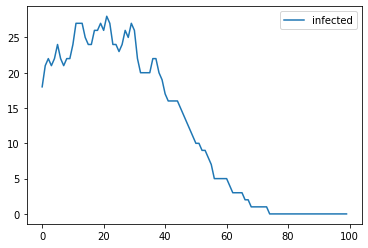

In [14]:
_ = m_df.plot.line(y='infected')

In [15]:
a_df = model.datacollector.get_agent_vars_dataframe()
a_df

state      speed   heading  time_infected
Step AgentID                                                      
0    0        State.UNAFFECTED  10.000000  2.131276       0.000000
     1        State.UNAFFECTED  10.000000  1.706667       0.000000
     2        State.UNAFFECTED  10.000000  4.751753       0.000000
     3        State.UNAFFECTED  10.000000  4.698713       0.000000
     4        State.UNAFFECTED  10.000000  3.848147       0.000000
...                        ...        ...       ...            ...
99   93       State.UNAFFECTED -17.355396  2.197168       0.000000
     95        State.RECOVERED   6.326999  1.821255      21.892501
     96        State.RECOVERED   1.798486 -1.833627      20.101806
     97        State.RECOVERED   2.144244 -2.030675      20.199078
     98        State.RECOVERED   7.536203 -3.389601      20.524909

[8186 rows x 4 columns]

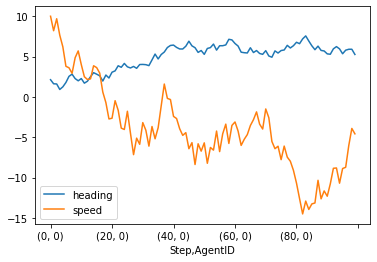

In [16]:
_ = a_df[a_df.index.get_level_values('AgentID') == 0].plot.line(y=['heading', 'speed'])

## Visualization

In [17]:
def plot_states_bokeh(model, iteration, total):
    X = model.datacollector.get_model_vars_dataframe()
    source = ColumnDataSource(X)
    colors = Category10[10]
    items = []
    p = figure(plot_width=600, plot_height=400, tools=[], title=f'step: {iteration}', x_range=(0,total))        
    for i, c in enumerate(X.columns):
        line = Line(x='index', y=c, line_color=colors[i], line_width=3, line_alpha=.8, name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c, [glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right', items=items))
    p.background_fill_color = "#ffffff"
    p.background_fill_alpha = 1
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

In [18]:
def plot_agents_bokeh(model):
    def plot_agents(p, agents, color):
        xx = list(map(lambda x: x.pos[0], agents))
        yy = list(map(lambda x: x.pos[1], agents))
        ss = list(map(lambda x: x.infection_radius, agents))
        p.circle_dot(x=xx, y=yy, size=ss, alpha=0.5, fill_color=color)
    
    agents = model.schedule.agents
    w = model.grid.width
    h = model.grid.height
    p = figure(plot_width=500, plot_height=500, x_range=(0, w), y_range=(0, h))
    
    plot_agents(p, list(filter(lambda x: x.state == State.INFECTED, agents)), "red")
    plot_agents(p, list(filter(lambda x: x.state == State.UNAFFECTED, agents)), "blue")
    plot_agents(p, list(filter(lambda x: x.state == State.RECOVERED, agents)), "green")
    
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

In [19]:
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
pn.Row(plot_pane, grid_pane, sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Bokeh(None)
    [1] Bokeh(None)

## Run simulation

In [20]:
model = EpidemicModel(
    N=100,
    initial_infection_p=.2,
    infection_p=.5,
    infection_r=30,
    infection_time_min=30,
    infection_end_p=0.7,
    death_p=0.6,
    initial_speed=10
)

TOTAL = 200
for i in range(TOTAL):
    model.step()
    plot_pane.object = plot_states_bokeh(model, i, TOTAL)
    grid_pane.object = plot_agents_bokeh(model)

### Ex. 5. Add metrics
- Implement _infected_ metric computation (`compute_infected` method)
- Rerun simulation to see if it works

### Ex. 6. Add death & recovery
- Implement (`try_die_or_recover` method) agent's recovery or death after some number of iterations (use `time_infected` parameter)
- Rerun simulation to see if it works

# Batch running

### Parameters definition

In [21]:
fixed_params = {
    'N': 100,
    'infection_p': 0.5,
    'infection_r': 30,
    'infection_time_min': 30,
    'infection_end_p': 0.7,
    'initial_speed': 10
}

variable_params = {
    'initial_infection_p': np.arange(0.1, 1, 0.1),
    'death_p': np.arange(0.1, 1, 0.1)
}

### Batch run

In [21]:
batch_run = BatchRunner(
    EpidemicModel,
    variable_params,
    fixed_params,
    iterations=3,
    max_steps=100,
    model_reporters={
        'alive': compute_alive,
        'infected': compute_infected,
        'dead': compute_dead,
        'recovered': compute_recovered
    }
)

batch_run.run_all()

243it [00:36,  6.73it/s]


### Results

In [22]:
vars_df = batch_run.get_model_vars_dataframe()
vars_df

,death_p,initial_infection_p,Run,alive,dead,infected,recovered,N,infection_p,infection_r,infection_time_min,infection_end_p,initial_speed
0,0.1,0.1,0,96,4,5,62,100,0.5,30,30,0.7,10
1,0.1,0.1,1,95,5,1,55,100,0.5,30,30,0.7,10
2,0.1,0.1,2,92,8,5,57,100,0.5,30,30,0.7,10
3,0.1,0.2,3,85,15,13,53,100,0.5,30,30,0.7,10
4,0.1,0.2,4,92,8,16,62,100,0.5,30,30,0.7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0.9,0.8,238,25,75,0,20,100,0.5,30,30,0.7,10
239,0.9,0.8,239,21,79,0,16,100,0.5,30,30,0.7,10
240,0.9,0.9,240,11,89,0,10,100,0.5,30,30,0.7,10
241,0.9,0.9,241,13,87,0,11,100,0.5,30,30,0.7,10


### Variables influence on metrics
_If the plot doesn't fit your screen, please adjust `figsize` paremeter._

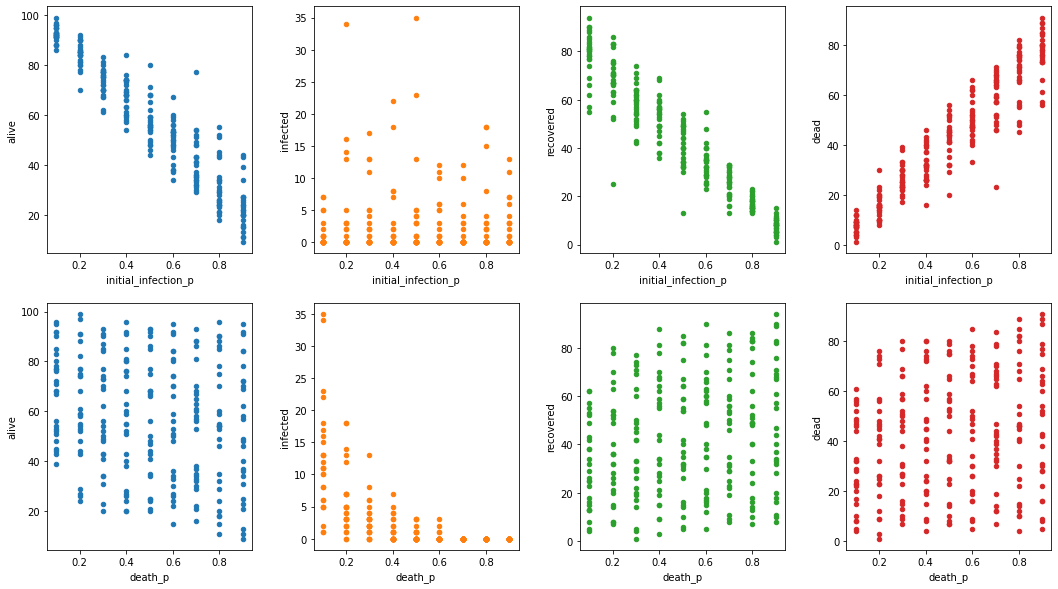

In [23]:
input_vars=variable_params.keys()
output_vars=['alive', 'infected', 'recovered', 'dead']

fig, ax = plt.subplots(len(input_vars), len(output_vars), figsize=(18, 10))
fig.subplots_adjust(wspace=0.3)
cmap = plt.get_cmap('tab10')
colors = [rgb2hex(cmap(c)) for c in range(cmap.N)]
for i, o in itertools.product(enumerate(input_vars), enumerate(output_vars)):
    i_idx, i_val = i
    o_idx, o_val = o
    vars_df.plot.scatter(x=i_val, y=o_val, ax=ax[i_idx, o_idx], c=colors[o_idx])